# Load Libraries

In [143]:
# Import useful libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

from category_encoders.m_estimate import MEstimateEncoder
from xgboost import XGBClassifier
import warnings

sns.set_theme()
warnings.filterwarnings("ignore")

# Load data set
train_ppath = "./train.csv"
test_path = "./test.csv"
orig_path = "./ObesityDataSet.csv"

train = pd.read_csv(train_ppath)
orig = pd.read_csv(orig_path)
test = pd.read_csv(test_path)

train = pd.concat([train, orig])
train.pop("id")

test_id = test["id"]
test.pop("id")

train.head()

Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  24.443011  1.699998   81.669950                            yes   
1  Female  18.000000  1.560000   57.000000                            yes   
2  Female  18.000000  1.711460   50.165754                            yes   
3  Female  20.952737  1.710730  131.274851                            yes   
4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  
3  0.780199  Sometimes  Public_Transportation     Obesity_Type_III  
4  0.931721  Sometimes  Public_Transportation  Overweight_Level_II

# Exploratory Data Analysis

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22869 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22869 non-null  object 
 1   Age                             22869 non-null  float64
 2   Height                          22869 non-null  float64
 3   Weight                          22869 non-null  float64
 4   family_history_with_overweight  22869 non-null  object 
 5   FAVC                            22869 non-null  object 
 6   FCVC                            22869 non-null  float64
 7   NCP                             22869 non-null  float64
 8   CAEC                            22869 non-null  object 
 9   SMOKE                           22869 non-null  object 
 10  CH2O                            22869 non-null  float64
 11  SCC                             22869 non-null  object 
 12  FAF                             22869 

In [145]:
train.notna().all(axis=0)

Gender                            True
Age                               True
Height                            True
Weight                            True
family_history_with_overweight    True
FAVC                              True
FCVC                              True
NCP                               True
CAEC                              True
SMOKE                             True
CH2O                              True
SCC                               True
FAF                               True
TUE                               True
CALC                              True
MTRANS                            True
NObeyesdad                        True
dtype: bool

In [146]:
train.describe()

Age        Height        Weight          FCVC           NCP  \
count  22869.000000  22869.000000  22869.000000  22869.000000  22869.000000   
mean      23.885263      1.700377     87.767610      2.443428      2.754344   
std        5.753419      0.087881     26.364243      0.533329      0.712711   
min       14.000000      1.450000     39.000000      1.000000      1.000000   
25%       20.000000      1.631662     66.000000      2.000000      3.000000   
50%       22.815416      1.700000     84.000000      2.392665      3.000000   
75%       26.000000      1.763029    111.531208      3.000000      3.000000   
max       61.000000      1.980000    173.000000      3.000000      4.000000   

               CH2O           FAF           TUE  
count  22869.000000  22869.000000  22869.000000  
mean       2.027442      0.984382      0.620551  
std        0.608901      0.839466      0.602850  
min        1.000000      0.000000      0.000000  
25%        1.755907      0.015860      0.000000  
50%        2.000000      1.000000      0.579541  
75%        2.535127      1.596576      1.000000  
max        3.000000      3.000000      2.000000

In [147]:
train.describe(include="object")

Gender family_history_with_overweight   FAVC       CAEC  SMOKE    SCC  \
count    22869                          22869  22869      22869  22869  22869   
unique       2                              2      2          4      2      2   
top     Female                            yes    yes  Sometimes     no     no   
freq     11465                          18740  20848      19294  22580  22086   

             CALC                 MTRANS        NObeyesdad  
count       22869                  22869             22869  
unique          4                      5                 7  
top     Sometimes  Public_Transportation  Obesity_Type_III  
freq        16467                  18267              4370

In [148]:
train.Age.round(0)

0       24.0
1       18.0
2       18.0
3       21.0
4       32.0
        ... 
2106    21.0
2107    22.0
2108    23.0
2109    24.0
2110    24.0
Name: Age, Length: 22869, dtype: float64

# Feature Engineering 

In [149]:
#train = train.drop("Weight", axis=1)
#test = test.drop("Weight", axis=1)

train["BMI"] = train["Weight"] / (train["Height"] ** 2)
test["BMI"] = test["Weight"] / (test["Height"] ** 2)

age_groups = [10, 20, 30, 40, 50, 60, 70]
labels = ["10+", "20+", "30+", "40+", "50+", "60+"]
train["Age_group"] = pd.cut(train.Age, bins=age_groups, labels=labels)
test["Age_group"] = pd.cut(test.Age, bins=age_groups, labels=labels)

X = train.loc[:, train.columns != "NObeyesdad"]
y = train[["NObeyesdad"]]

X.select_dtypes(include=["object", "category"]).nunique()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_features = X.select_dtypes(include=["int", "float"]).columns.tolist()

# Data Visualisation 

<Axes: xlabel='BMI', ylabel='NObeyesdad'>

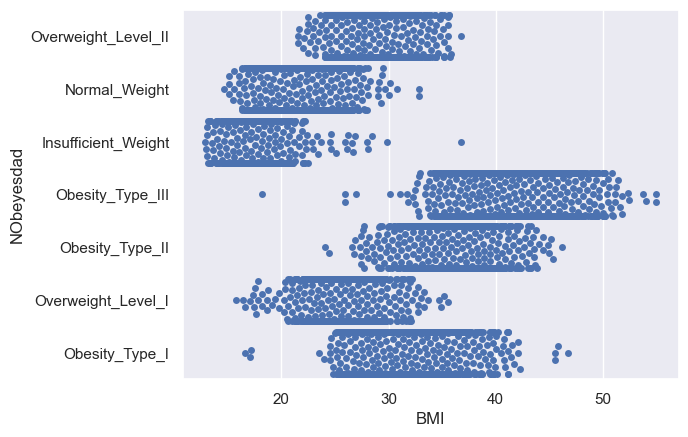

In [16]:
sns.swarmplot(train, y = "NObeyesdad", x = "BMI")

In [17]:
conditions = [
    (train['NObeyesdad'] == 'Insufficient_Weight') & (train['BMI'] >= 18.5),
    (train['NObeyesdad'] == 'Normal_Weight') & (train['BMI'] < 18.5),
    (train['NObeyesdad'] == 'Normal_Weight') & (train['BMI'] >= 25),
    (train['NObeyesdad'] == 'Overweight_Level_I') & (train['BMI'] < 25),
    (train['NObeyesdad'] == 'Overweight_Level_I') & (train['BMI'] >= 30),
    (train['NObeyesdad'] == 'Overweight_Level_II') & (train['BMI'] < 25),
    (train['NObeyesdad'] == 'Overweight_Level_II') & (train['BMI'] >= 30),
    (train['NObeyesdad'] == 'Obesity_Type_I') & (train['BMI'] < 20),
    (train['NObeyesdad'] == 'Obesity_Type_II') & (train['BMI'] < 20),
    (train['NObeyesdad'] == 'Obesity_Type_III') & (train['BMI'] < 20)
]

# Combine all conditions using logical OR
combined_condition = pd.concat(conditions, axis=1).any(axis=1)

# Filter the DataFrame using the combined condition
train = train[~combined_condition]


<Axes: xlabel='BMI', ylabel='NObeyesdad'>

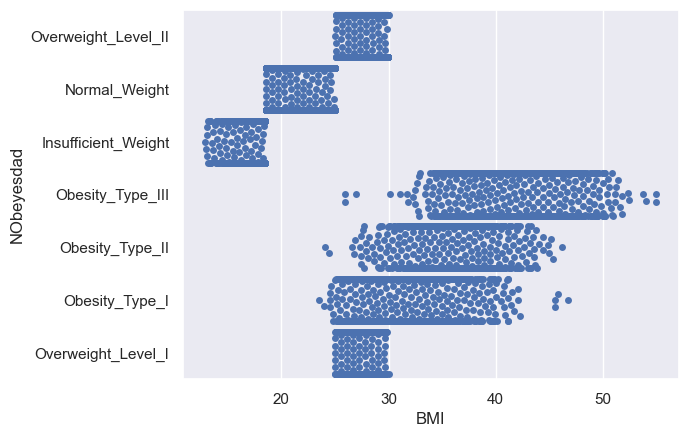

In [18]:
sns.swarmplot(train, y = "NObeyesdad", x = "BMI")

([<matplotlib.patches.Wedge at 0x2199f2a28d0>,
 [Text(0.0010499771077541965, 1.0999994988853738, 'Male'),
  Text(-0.0010498741183687732, -1.099999498983675, 'Female')])

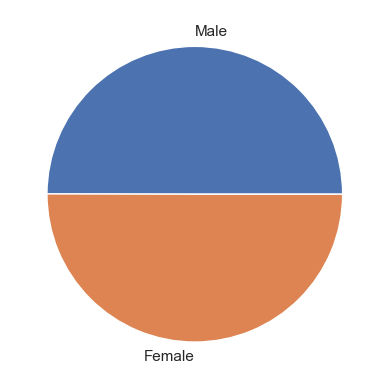

In [19]:
genders = train.groupby("Gender")["Gender"].value_counts()
plt.pie(genders, labels=["Male", "Female"])

<Axes: xlabel='Age_group', ylabel='Count'>

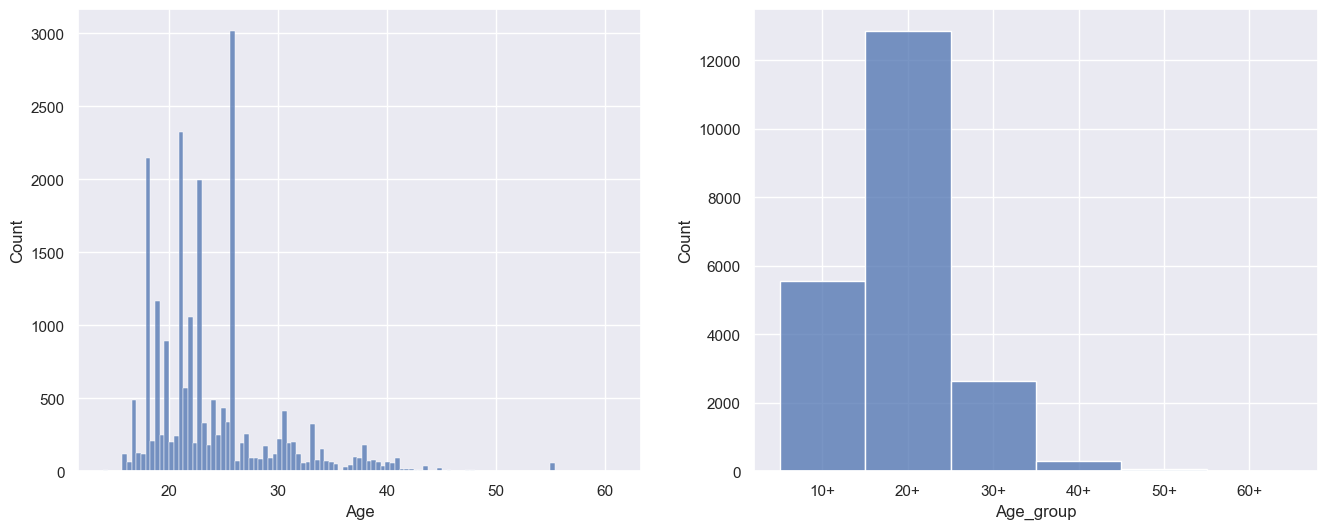

In [20]:
f, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(train.Age, ax=axes[0], stat="count")
sns.histplot(train.Age_group, ax=axes[1])

<Axes: xlabel='Weight', ylabel='Count'>

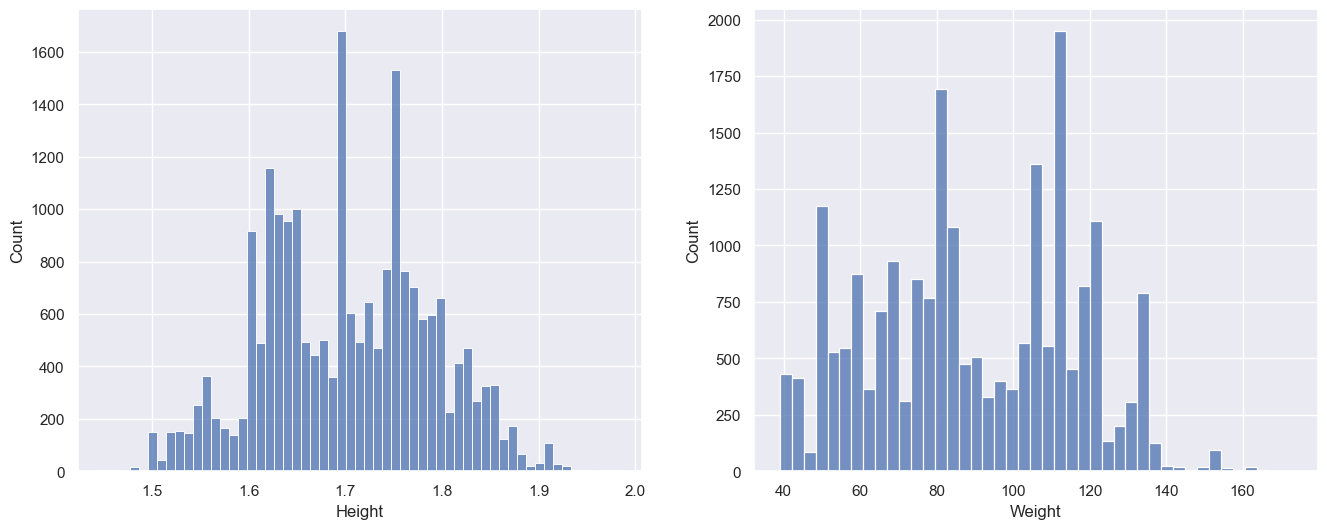

In [21]:
f, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(train.Height, ax=axes[0], stat="count")
sns.histplot(train.Weight, stat="count", ax=axes[1])

<Axes: xlabel='family_history_with_overweight', ylabel='Count'>

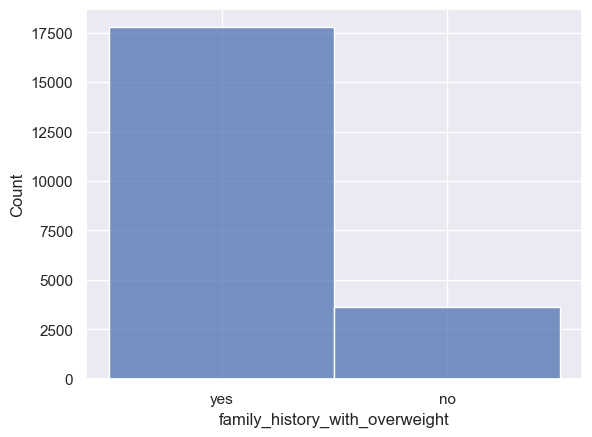

In [22]:
sns.histplot(data=train, x = "family_history_with_overweight")

In [23]:
eating_habits = ["FAVC", "FCVC", "NCP", "CAEC", "CH2O", "CALC"]
lifestyl = ["SMOKE", "SCC", "FAF", "TUE", "MTRANS"]

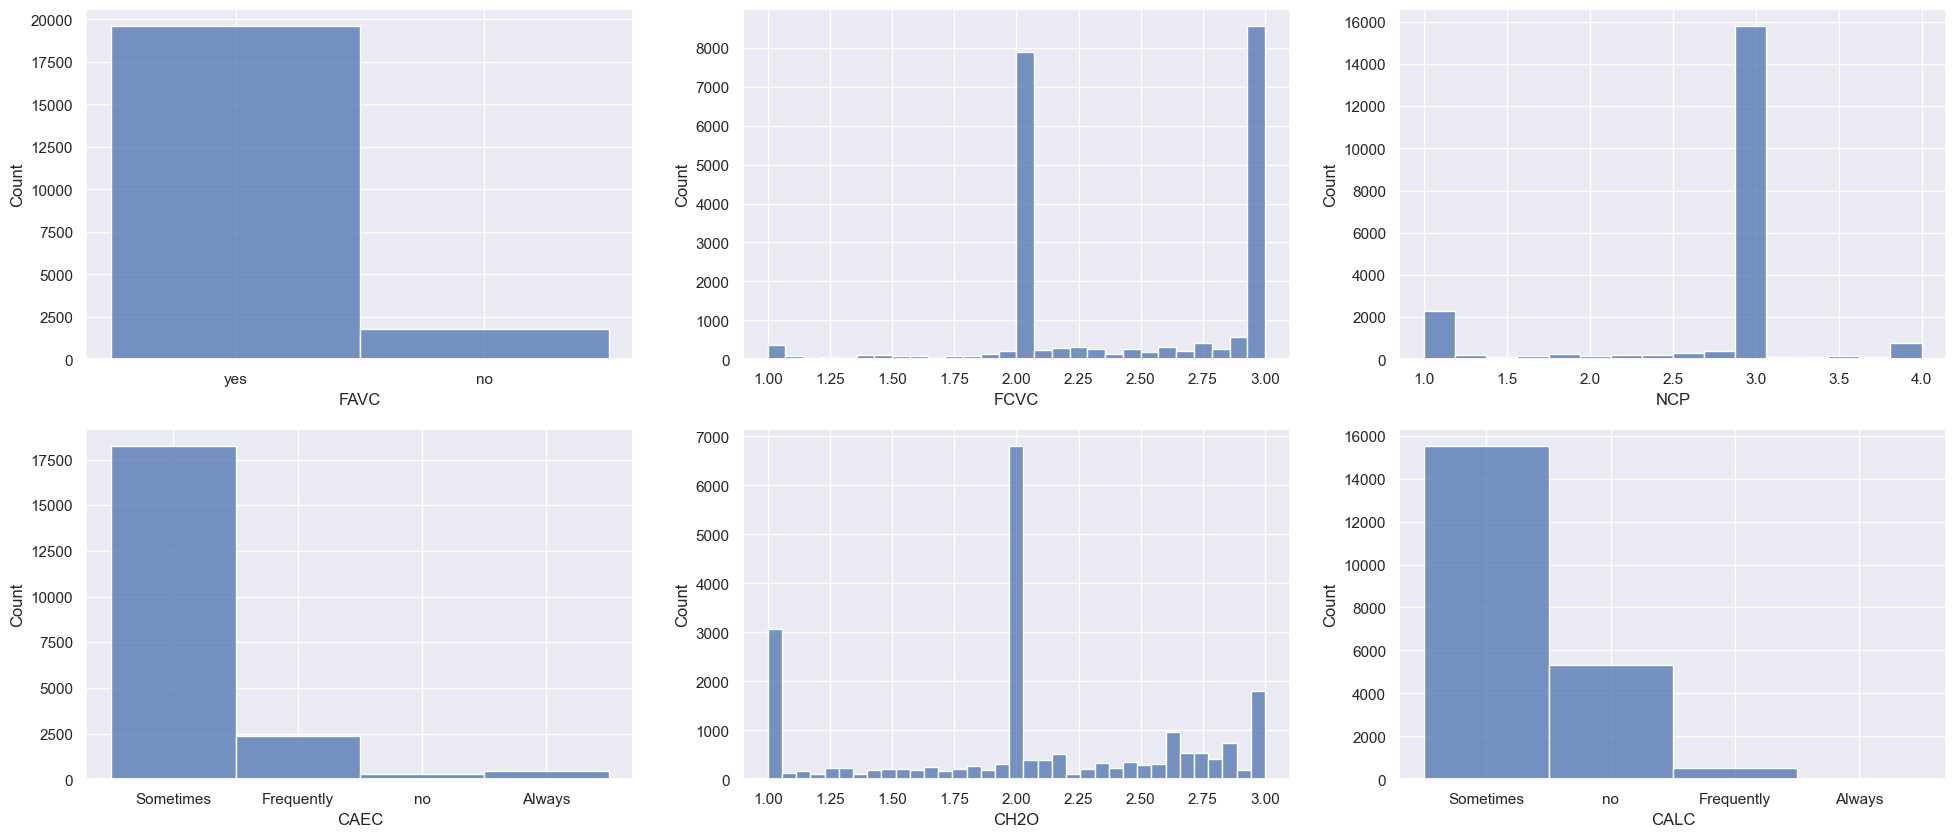

In [24]:
f, axes = plt.subplots(2, 3, figsize=(24, 10))
for i, habits in enumerate(eating_habits):
    if i < 3:
        sns.histplot(train, x = habits, ax=axes[0, i])
    else:
        sns.histplot(train, x = habits, ax=axes[1, i % 3])

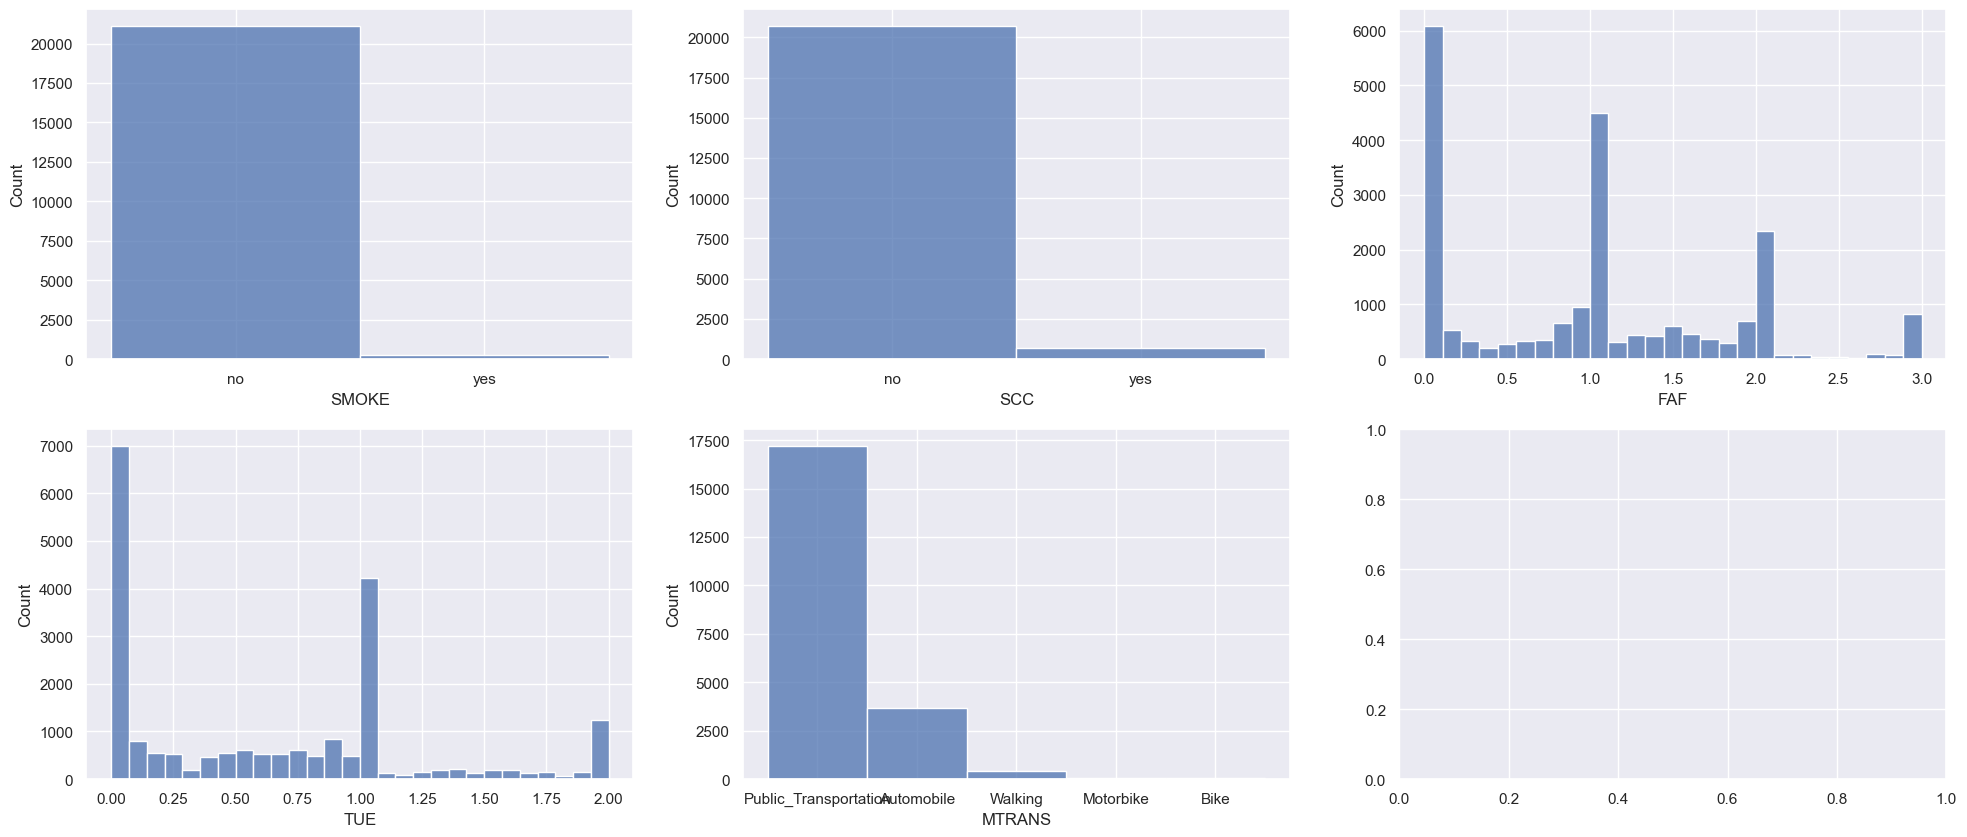

In [25]:
f, axes = plt.subplots(2, 3, figsize=(24, 10))
for i, style in enumerate(lifestyl):
    if i < 3:
        sns.histplot(train, x = style, ax=axes[0, i])
    else:
        sns.histplot(train, x = style, ax=axes[1, i % 3])

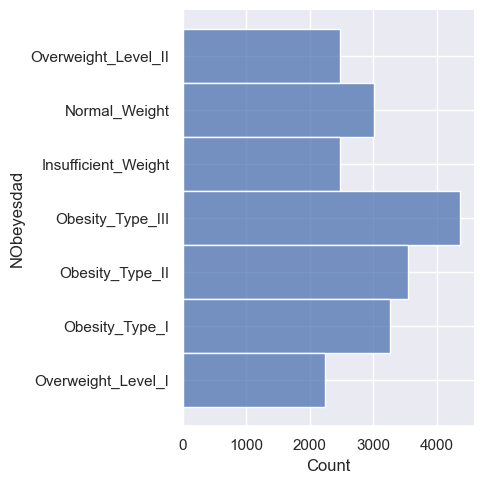

In [26]:
sns.displot(train, y = "NObeyesdad")

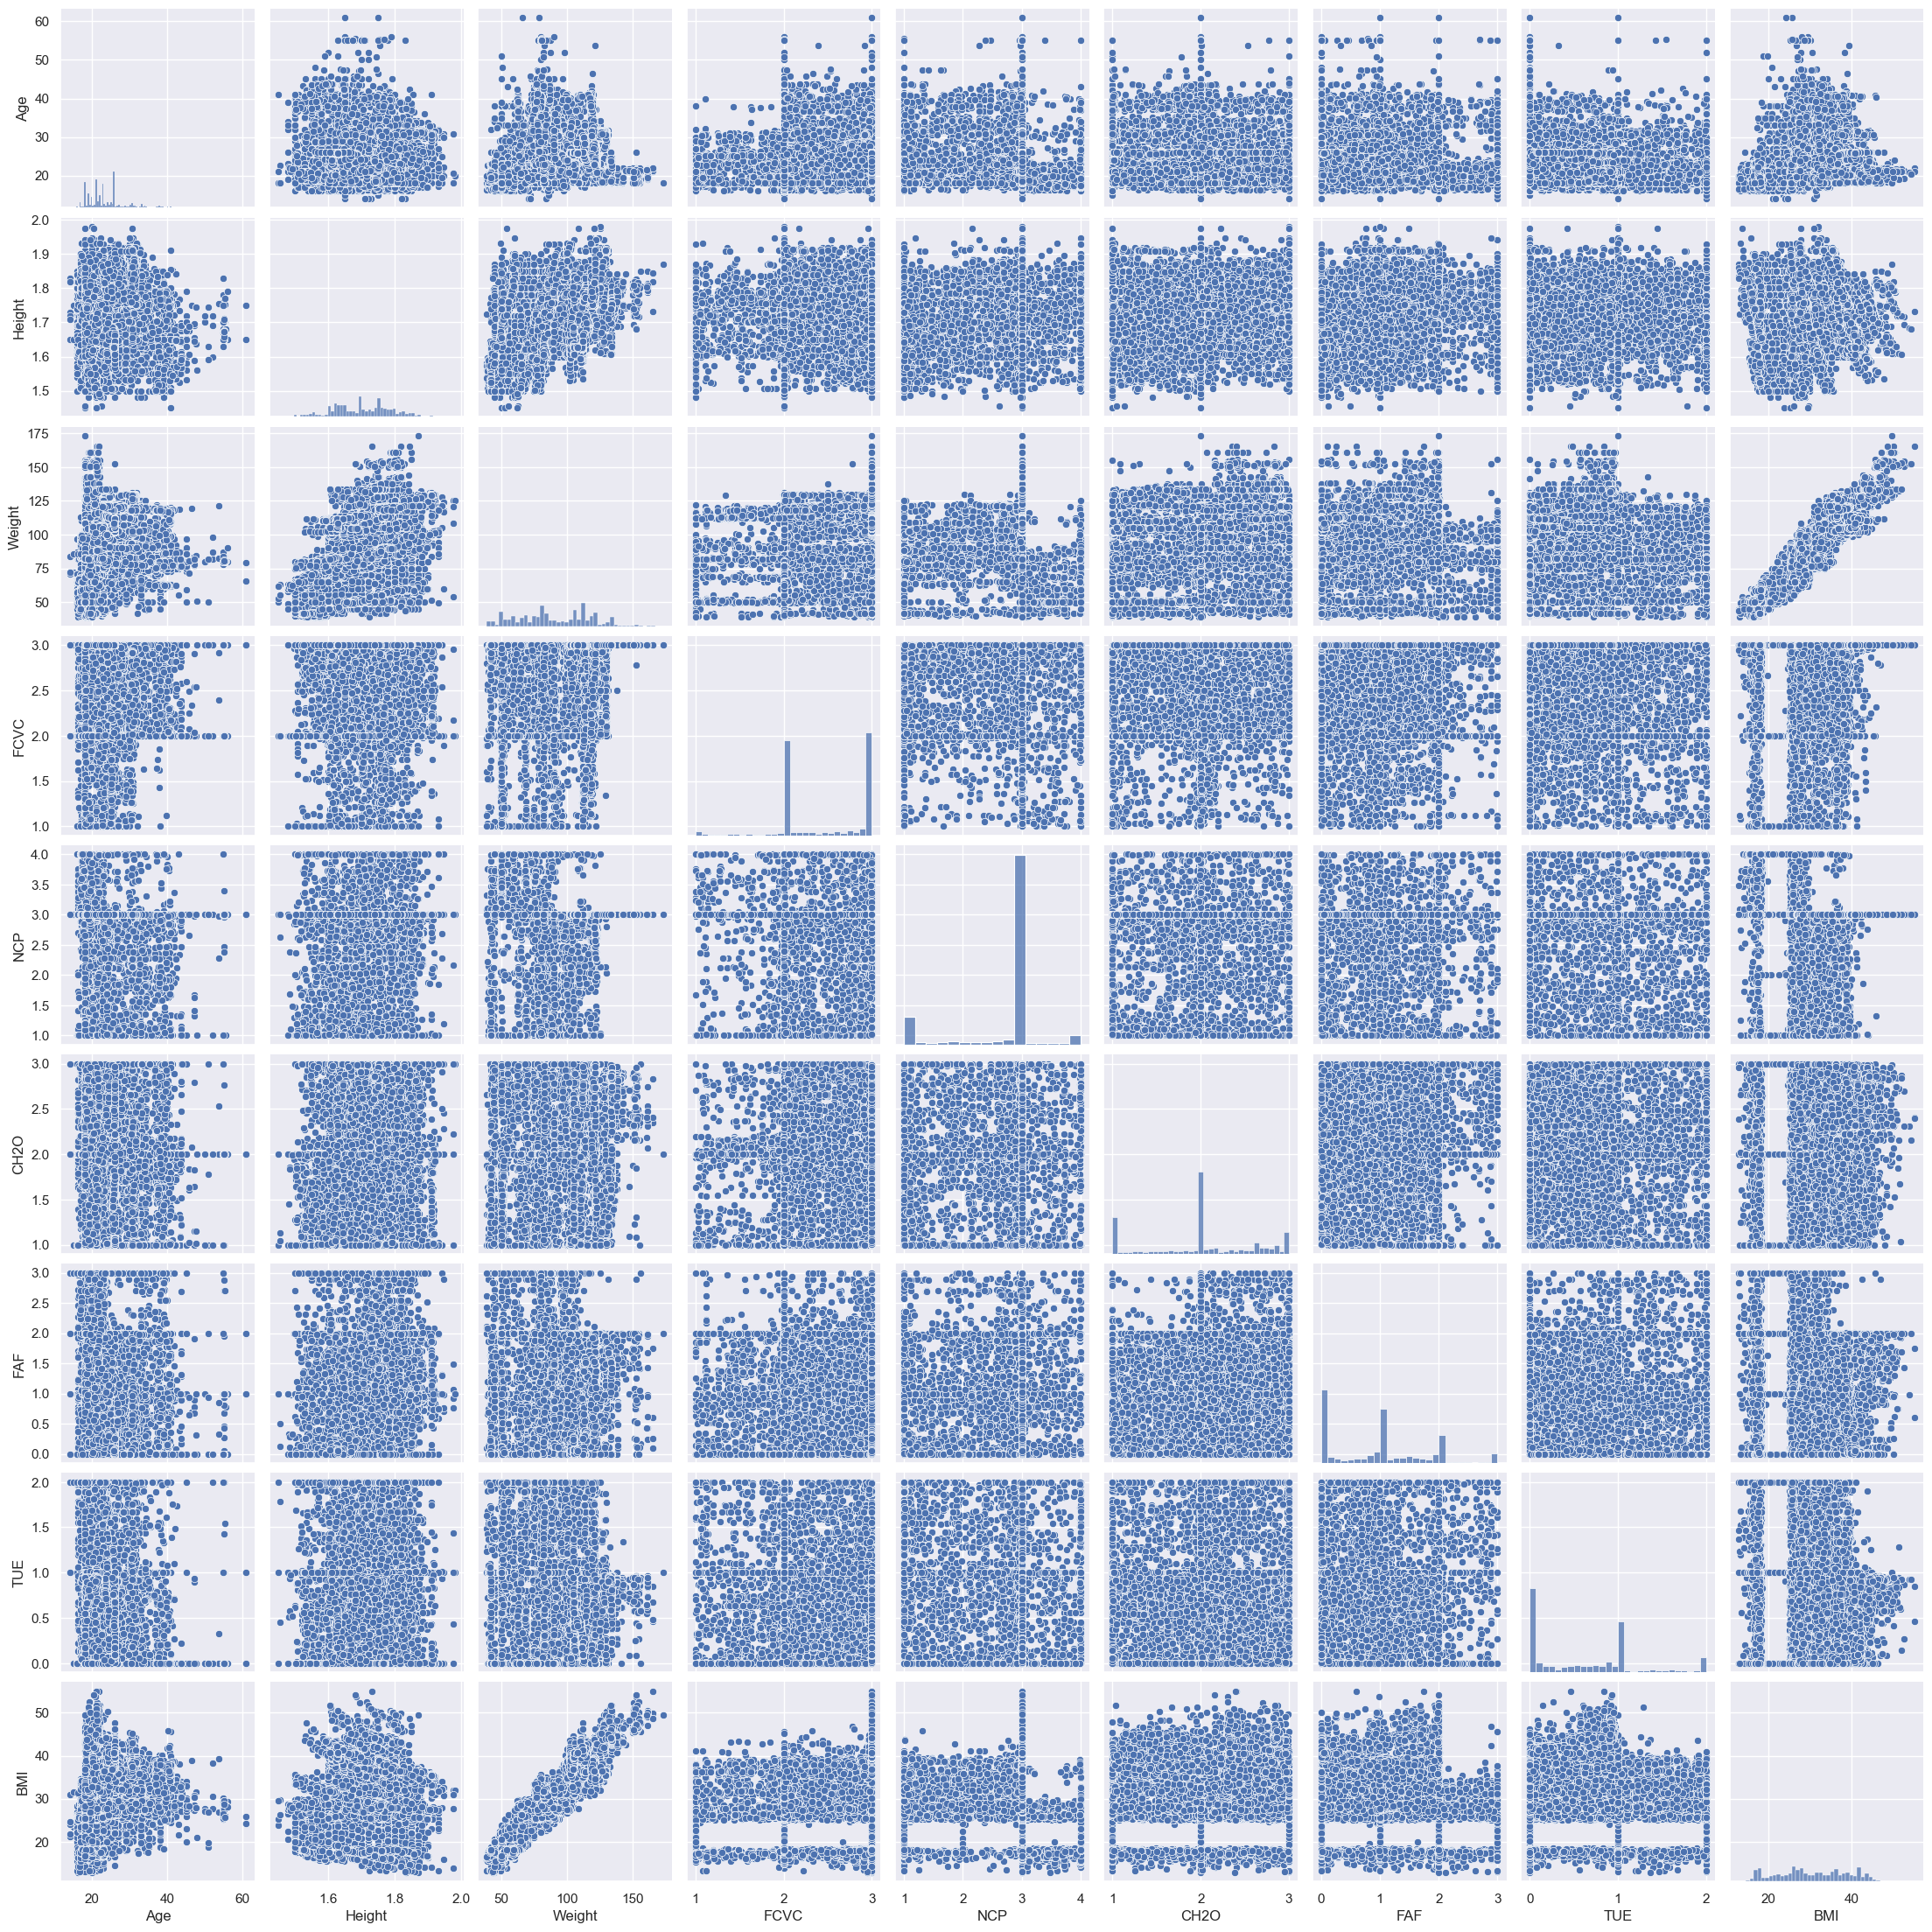

In [27]:
sns.pairplot(train)

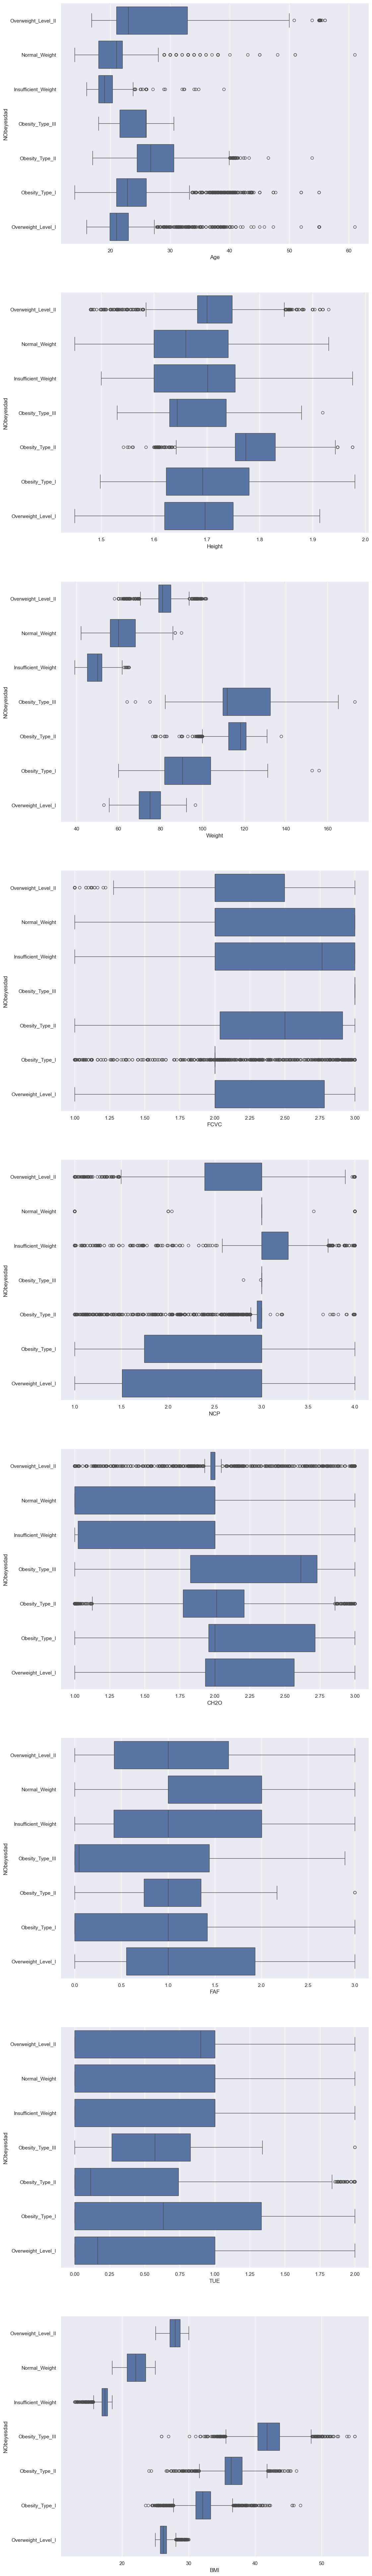

In [28]:
###f, axes = plt.subplots(9, 2, figsize=(30, 24))
"""for i, feat in enumerate(tmp):
    for j in range(2):
        if i < 9:
            sns.boxplot(train, x = feat, y = "NObeyesdad", orient = 'h', ax = axes[i, j])
        else:
            sns.boxplot(train, x = feat, y = "NObeyesdad", orient = 'h', ax = axes[i % 9, j])"""

f, axes = plt.subplots(len(numeric_features), 1, figsize = (12, 100))

for i, feat in enumerate(numeric_features):
    sns.boxplot(train, x = feat, y = "NObeyesdad", ax = axes[i])


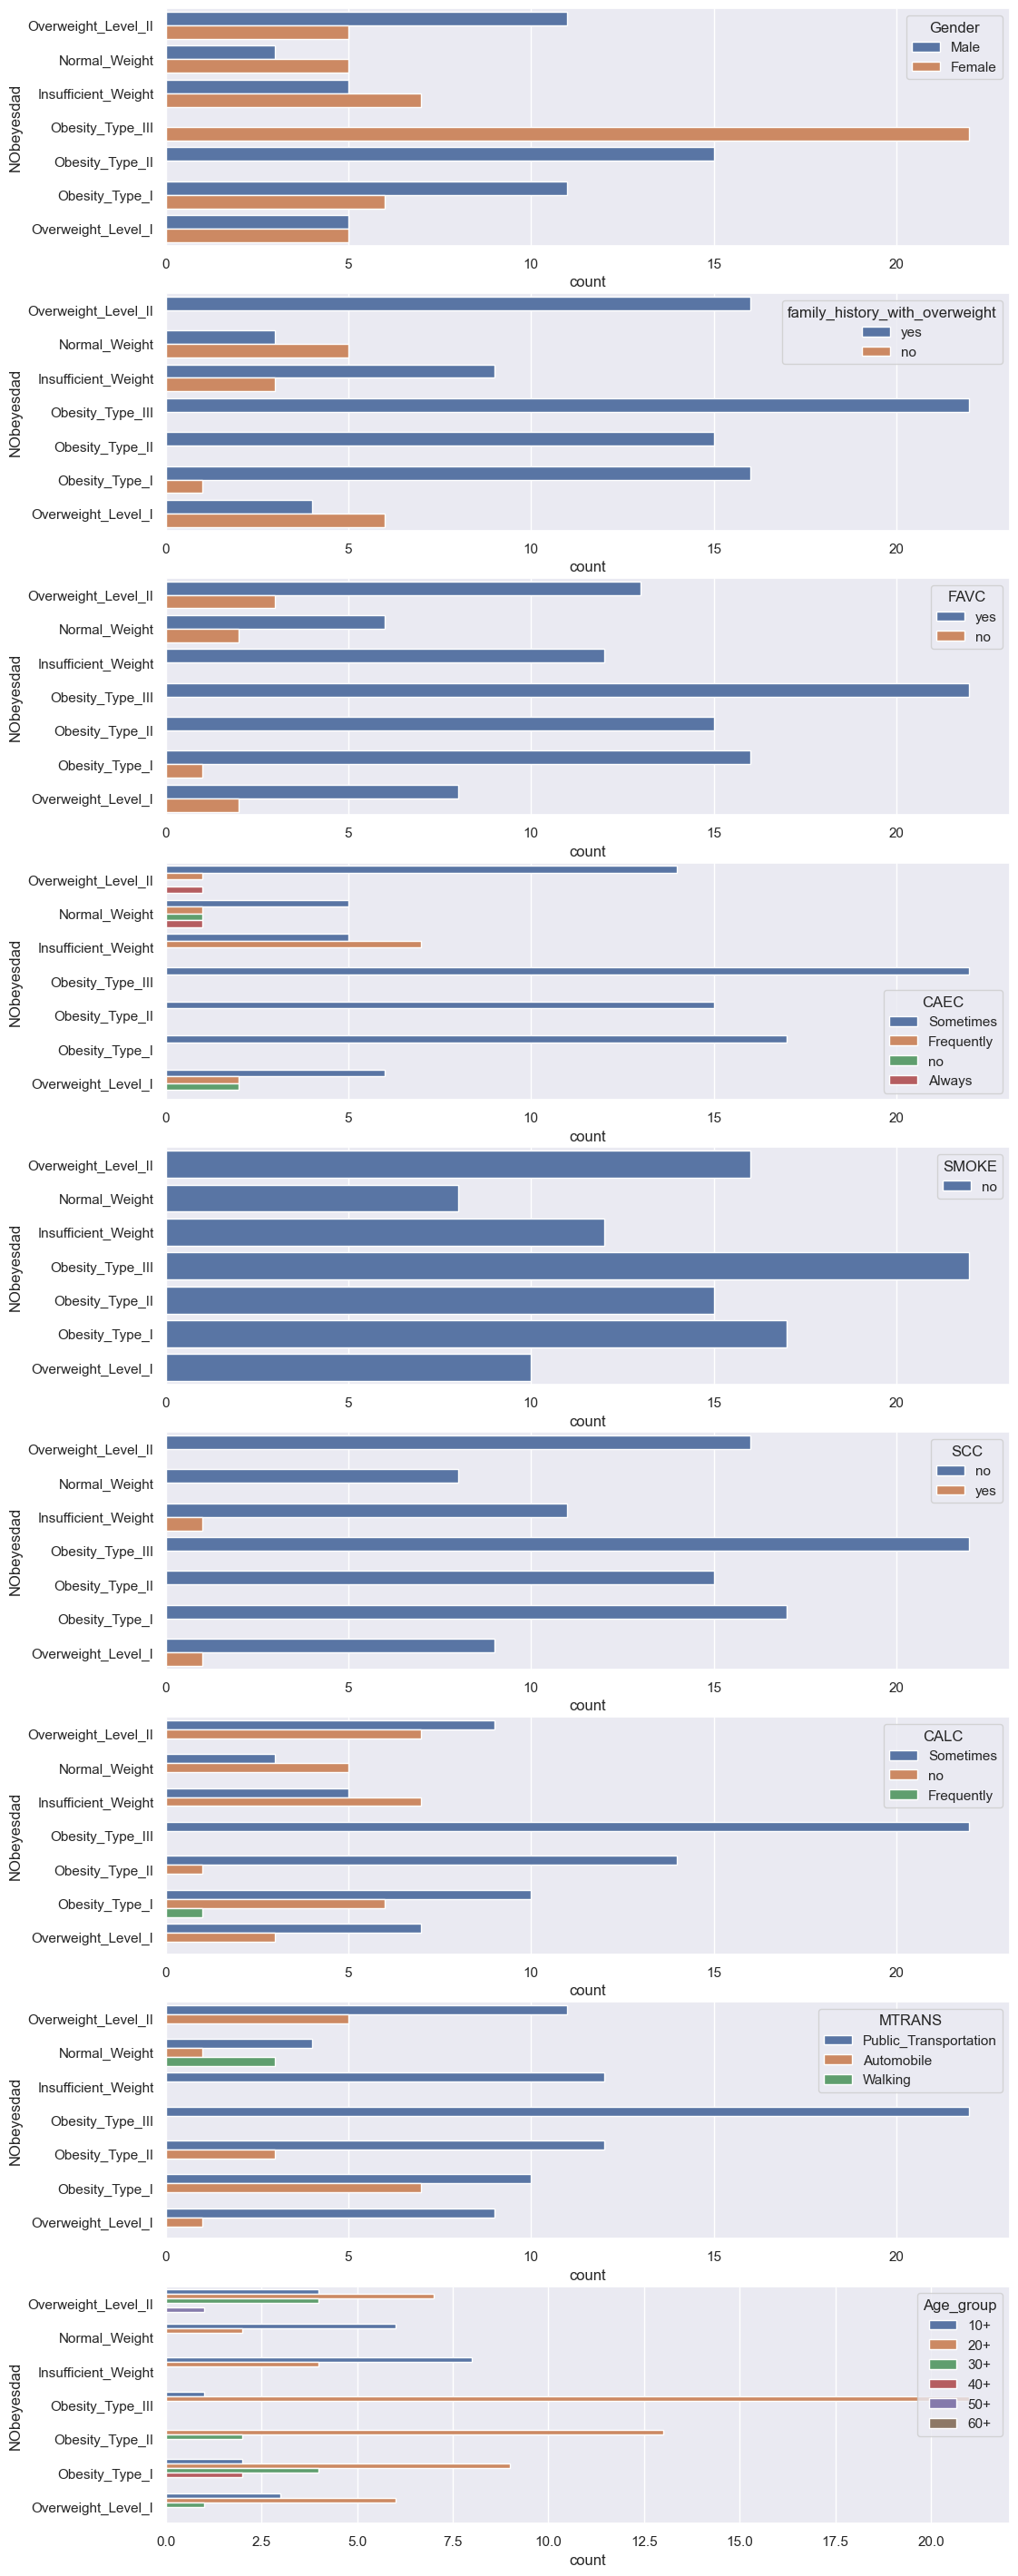

In [29]:
f, axes = plt.subplots(len(categorical_features), 1, figsize = (12, 36))
for i, feat in enumerate(categorical_features):
    sns.countplot(train[:100], y = "NObeyesdad", hue = feat, ax=axes[i])

In [30]:
train["NObeyesdad"].value_counts()

NObeyesdad
Obesity_Type_III       4369
Obesity_Type_II        3545
Obesity_Type_I         3258
Normal_Weight          3020
Overweight_Level_II    2483
Insufficient_Weight    2477
Overweight_Level_I     2241
Name: count, dtype: int64

# Mutual Information

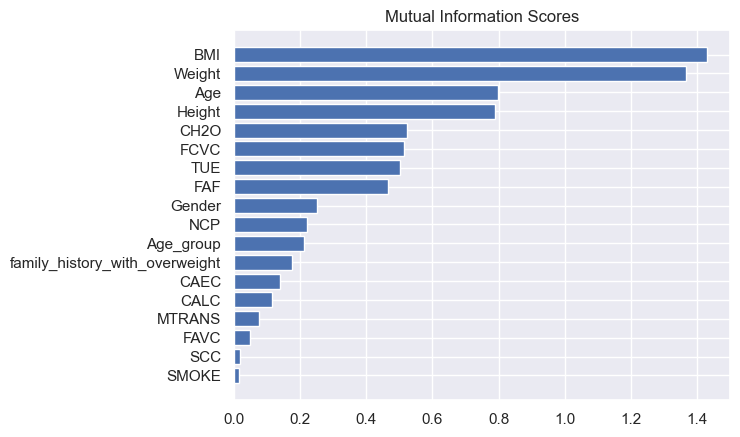

In [137]:
encoder = OrdinalEncoder()

preprocessor = ColumnTransformer(transformers=[
    ("cat", OrdinalEncoder(), categorical_features),
    ("scaler", StandardScaler(), numeric_features)
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train))

X_train_transformed.columns = categorical_features + numeric_features

mutual_info_classif(X_train_transformed, y_train)

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

scores = make_mi_scores(X_train_transformed, y_train)
plot_mi_scores(scores)

From the graph we plotted above, the most important features are BMI and Weight, followed by Age, Height, CH2O, FCVC, TUE, FAF, etc. We here exclude BMI, and will only choose
["Weight", "Age", "Height", "CH2O", "FCVC", "TUE", "FAF"] as our features to build our model.

# Prediction

## Cross Validation Model and Helper Functions

In [150]:
""" 
* Found out that there is a method called 
* sklearn.model_selection.cross_val_score doing the same thing
* But we will still use the function we wrote, as we can gain more return values, and also we can manipulate the function freely
"""

features = ["Weight", "Age", "Height", "CH2O", "FCVC", "TUE", "FAF"]

target_mapping = {
    'Insufficient_Weight':0,
    'Normal_Weight':1,
    'Overweight_Level_I':2,
    'Overweight_Level_II':3, 
    'Obesity_Type_I':4,
    'Obesity_Type_II':5 ,
    'Obesity_Type_III':6
}

y = train[["NObeyesdad"]]

TARGET = "NObeyesdad" 

def cross_val_model(estimators, n_splits=10, verbose=True, use_all_features=True):

    """
    @param estimators: pipeline consists of preprocessing, encoder as well as model
    @param n_splits: number of folds for cross validation, default=10
    @param verbose: print train/valid score, default=True
    @param use_all_features: whether to use all features to build the model, default=True
    """
    
    skf = StratifiedKFold(n_splits=n_splits)

    X = train.copy()
    y = X.pop(TARGET)
    test_df = test.copy()
    
    # whether to use all features to build our model
    if not use_all_features:
        X = X[features]
        test_df = test_df[features]

    y = y.map(target_mapping)



    test_predictions = np.zeros((len(test_df), 7))
    valid_predictions = np.zeros((len(X), 7))

    valid_scores, train_scores = [], []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        #model = clone(estimators)
        model = estimators

        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        X_valid = X.iloc[valid_idx]
        y_valid = y.iloc[valid_idx]

        model.fit(X_train, y_train)

        if verbose:
            print("-" * 100)
            print(f"Fold: {fold + 1}")
            print(f"Train Accuracy Score:\t{accuracy_score(y_true=y_train, y_pred=model.predict(X_train))}")
            print(f"Test Accuracy Score:\t{accuracy_score(y_true=y_valid, y_pred=model.predict(X_valid))}")
            print("-"*100)

        test_predictions += model.predict_proba(test_df) / skf.get_n_splits()
        valid_predictions[valid_idx] = model.predict_proba(X_valid)

        train_scores.append(accuracy_score(y_true=y_train, y_pred=model.predict(X_train)))
        valid_scores.append(accuracy_score(y_true=y_valid, y_pred=model.predict(X_valid)))

    if verbose:
        print(f"Average Mean Accuracy Score:\t{np.array(valid_scores).mean()}")
    return train_scores, valid_scores, valid_predictions, test_predictions

In [151]:
def feature_importance_plot(model, use_all_features=True) -> None:
    feature_importance = model.steps[-1][1].feature_importances_

    if use_all_features:
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    else:
        feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('')
    sns.despine(left=True, bottom=True)
    plt.show()

def confusion_matrix_plot(valid_predictions: pd.DataFrame) -> None:
    y_labelled = y.applymap(lambda x: target_mapping[x])
    valid_predictions = pd.DataFrame(valid_predictions)
    valid_predictions_copy = valid_predictions.idxmax(axis=1)

    plt.figure(figsize=(20, 10))
    conf_matrix = confusion_matrix(y_labelled, valid_predictions_copy)
    conf_labels = [  
        'Insufficient_Weight',
        'Normal_Weight',
        'Overweight_Level_I',
        'Overweight_Level_II', 
        'Obesity_Type_I',
        'Obesity_Type_II',
        'Obesity_Type_III']
    conf_matrix_df = pd.DataFrame(conf_matrix, columns=conf_labels, index=conf_labels)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(np.arange(conf_matrix.shape[0]), conf_labels, rotation=45)
    plt.yticks(np.arange(conf_matrix.shape[0]), conf_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
    plt.grid(False)
    plt.show()

def train_test_log(train_scores: pd.DataFrame, valid_scores: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.plot(train_scores, marker='o', label=["Train Score"])
    plt.plot(valid_scores, marker='o', label=['Test Score'])
    plt.xlabel('n_estimators')
    plt.ylabel('Score')
    plt.title('Train Score vs. Test Score')
    plt.legend()
    plt.grid(True)
    plt.show()

## Decision Tree

----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:	0.9999480600425907
Test Accuracy Score:	0.9149532710280374
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:	1.0
Test Accuracy Score:	0.9196261682242991
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:	0.9999480600425907
Test Accuracy Score:	0.9196261682242991
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 4
Train Accuracy Score:	0.999948062

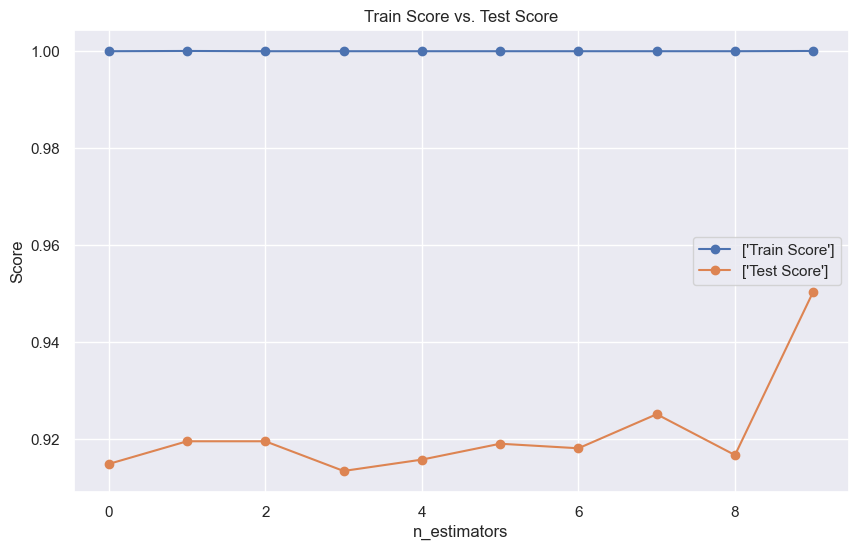

In [85]:
tree = make_pipeline(
    MEstimateEncoder(cols=categorical_features),
    StandardScaler(),
    DecisionTreeClassifier()
)

train_scores, valid_scores, valid_predictions, test_predictions = cross_val_model(tree, n_splits=10, use_all_features=True)

train_test_log(train_scores, valid_scores)

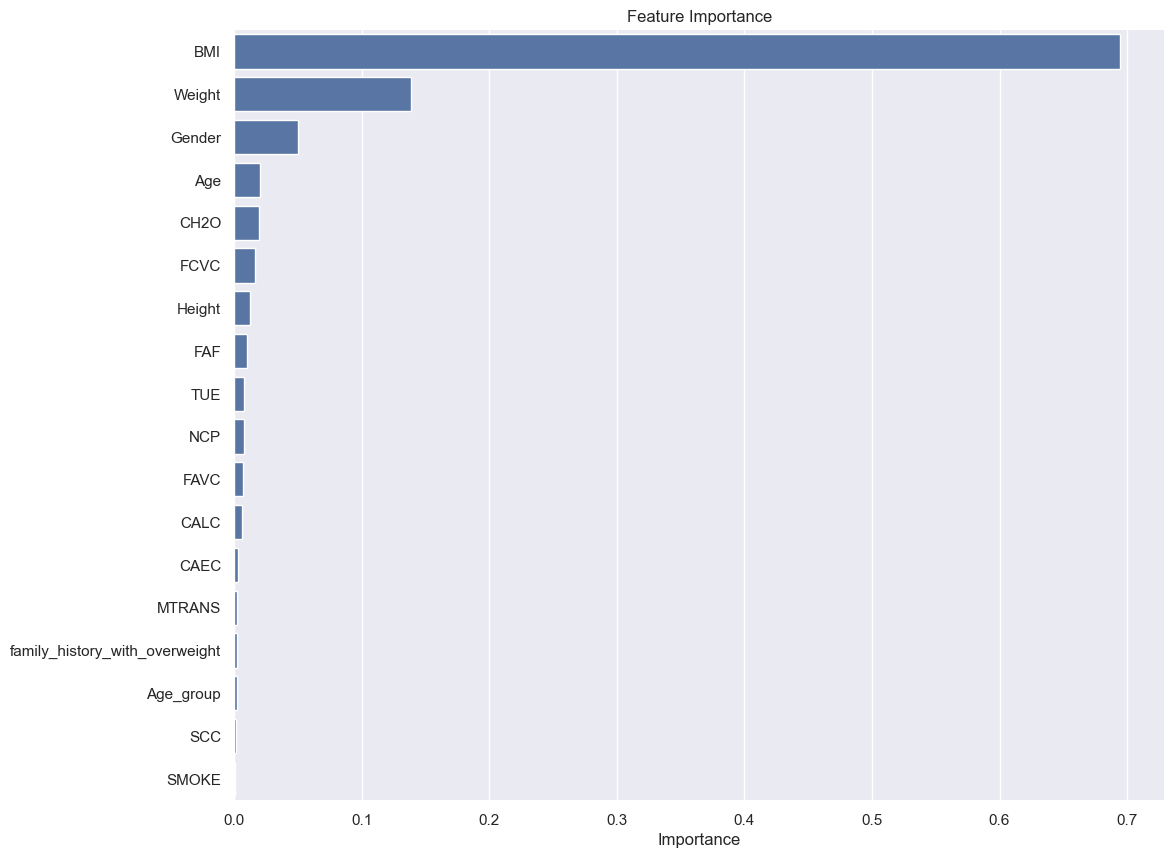

In [86]:
feature_importance_plot(tree)

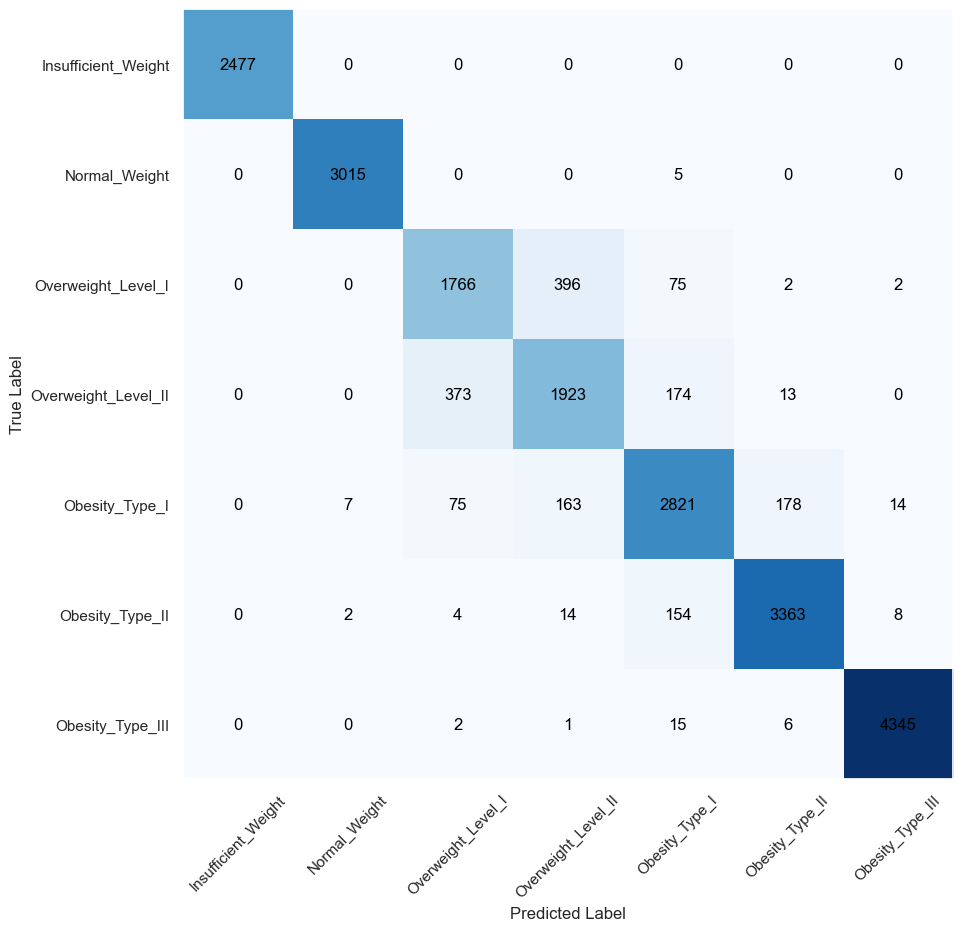

In [87]:
confusion_matrix_plot(valid_predictions)

## Random Forest

----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:	0.9999480600425907
Test Accuracy Score:	0.9448598130841122
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:	1.0
Test Accuracy Score:	0.9509345794392523
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:	0.9999480600425907
Test Accuracy Score:	0.9415887850467289
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 4
Train Accuracy Score:	0.999948062

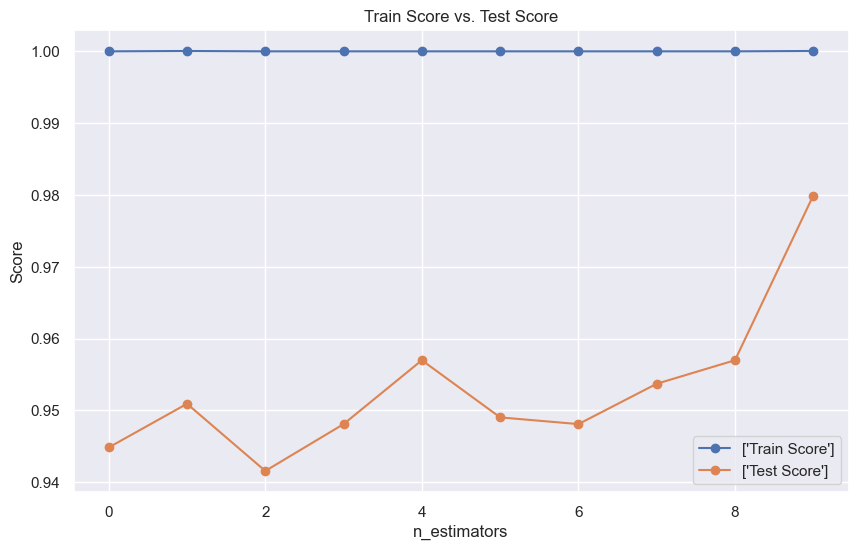

In [76]:
params = {
    "n_estimators": 1000,
    "n_jobs": -1,
}

RandForest = make_pipeline(
    MEstimateEncoder(cols=categorical_features),
    StandardScaler(),
    RandomForestClassifier(**params)
)

train_scores, valid_scores, valid_predictions, test_predictions = cross_val_model(RandForest, n_splits=10, use_all_features=True)

train_test_log(train_scores, valid_scores)

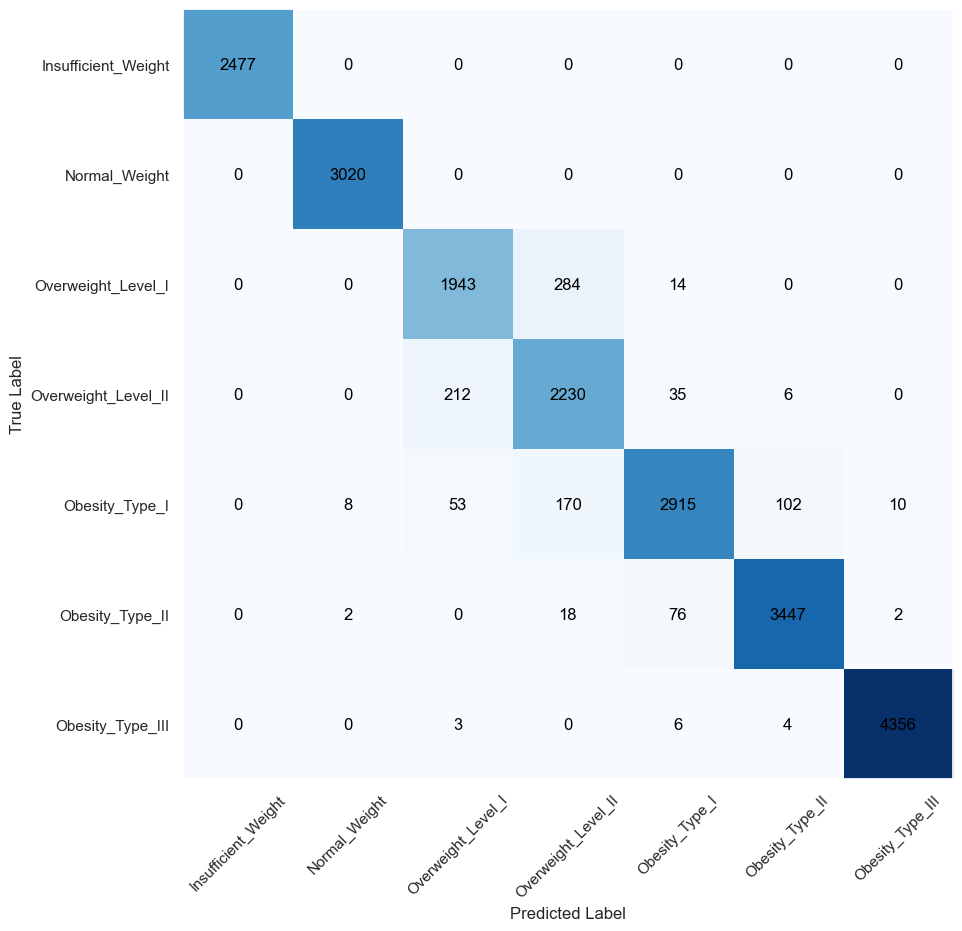

In [77]:
confusion_matrix_plot(valid_predictions)

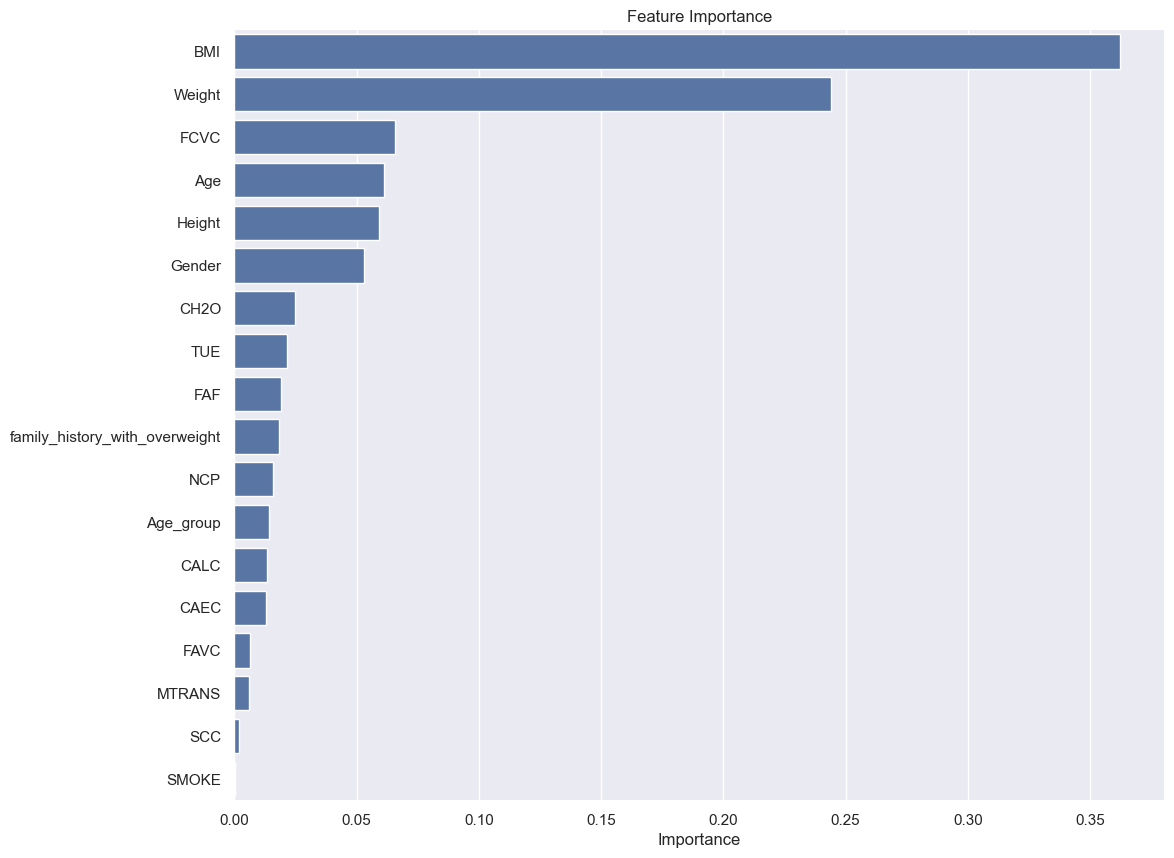

In [78]:
feature_importance_plot(RandForest, use_all_features=True)

## XGBClassifier

----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:	0.9821845946086324
Test Accuracy Score:	0.9411214953271028
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:	0.9810419155456293
Test Accuracy Score:	0.9481308411214954
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:	0.9814574352049031
Test Accuracy Score:	0.938785046728972
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 4
Train Accuracy Scor

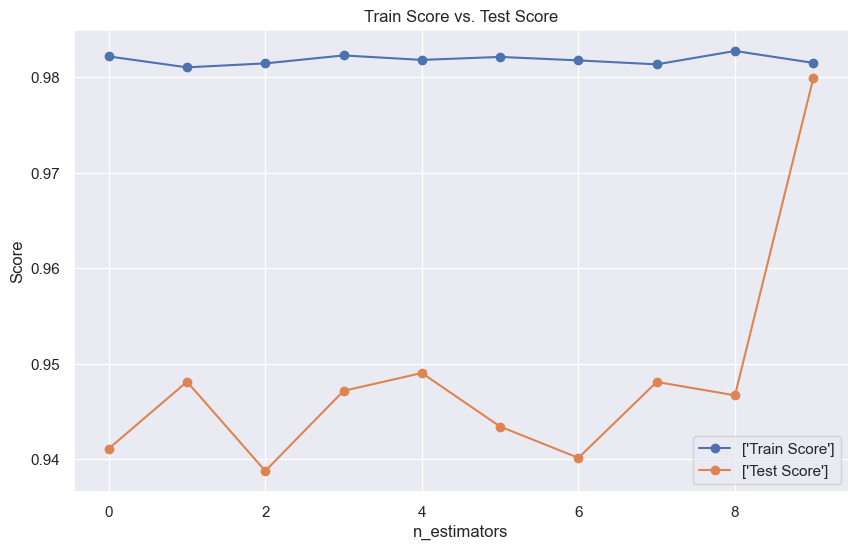

In [79]:
params = {
    "n_estimators": 1000,
    "learning_rate": 0.001,
    "booster": "gbtree", 
    "verbosity": 0,
    "max_depth": 25, 
    "n_jobs": -1,
    "tree_method": "gpu_hist",
    "objective": "multi:softmax",
}

XGB = make_pipeline(
    MEstimateEncoder(cols=categorical_features), 
    StandardScaler(),
    XGBClassifier(**params)
)

train_scores, valid_scores, valid_predictions, test_predictions = cross_val_model(XGB, n_splits=10, use_all_features=True)

train_test_log(train_scores, valid_scores)

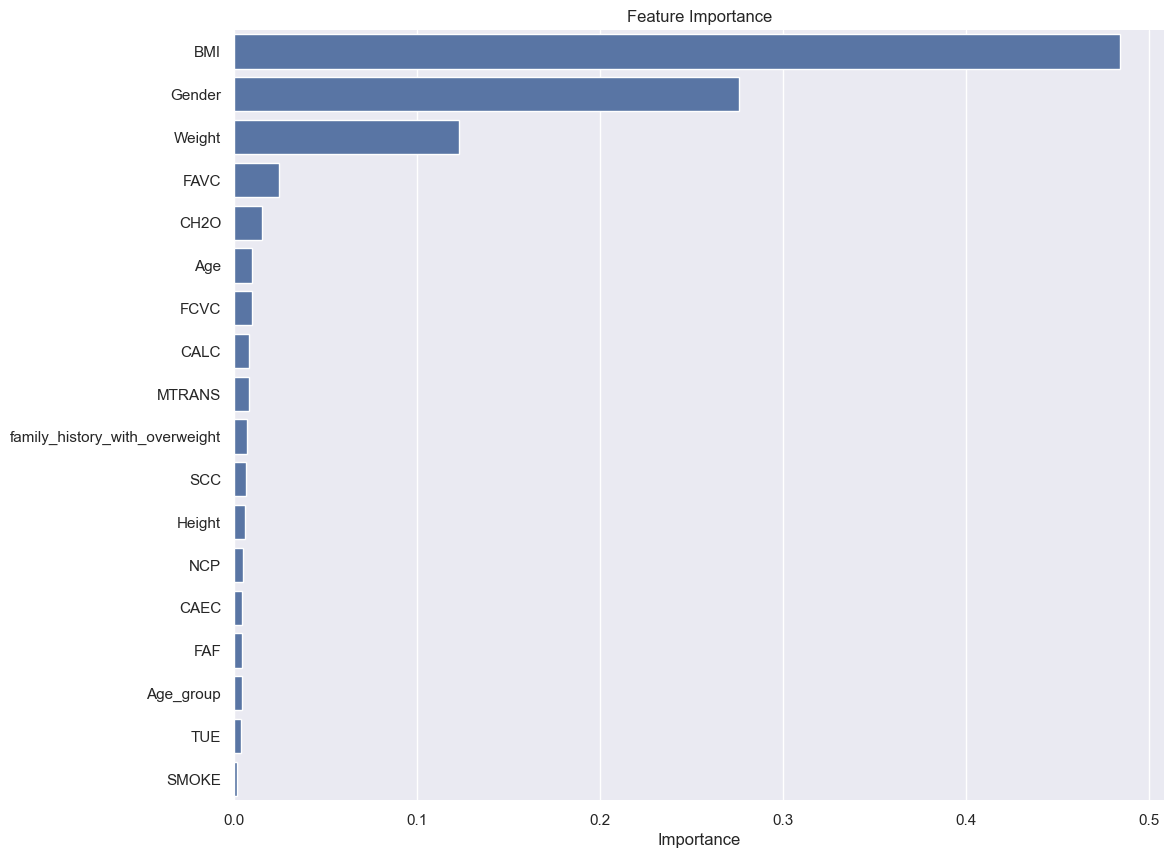

In [80]:
feature_importance_plot(XGB, use_all_features=True)

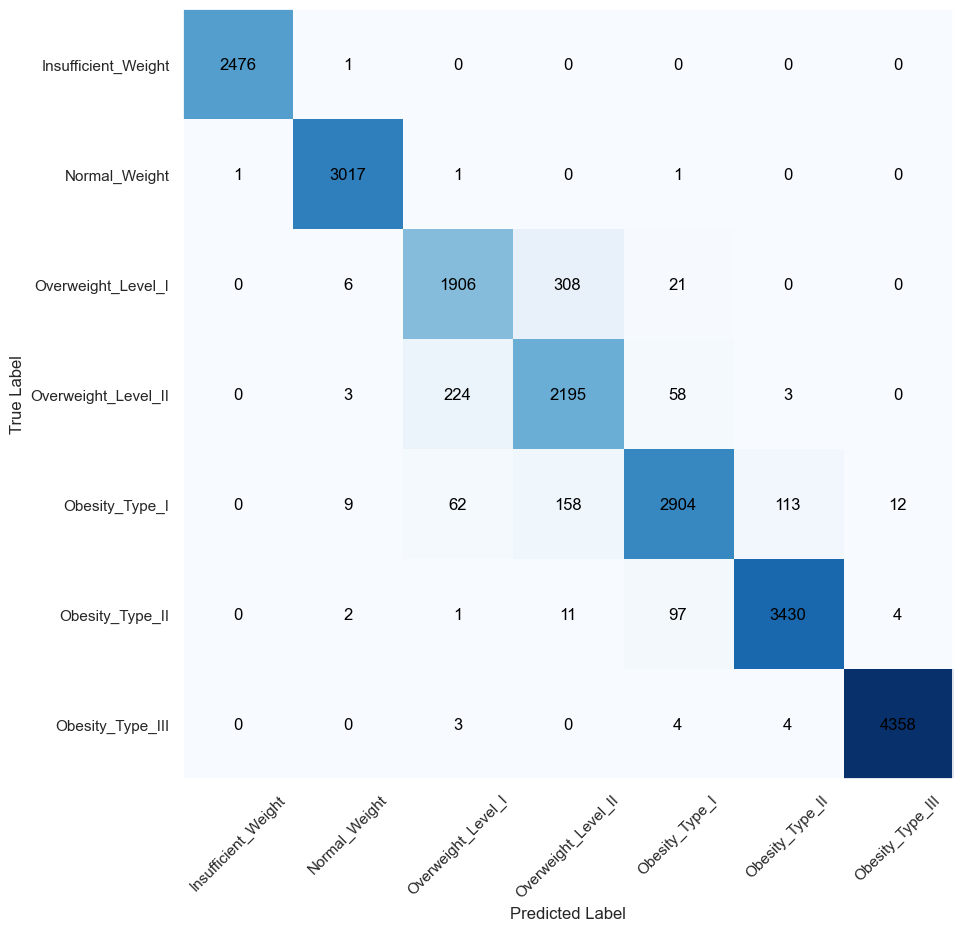

In [81]:
confusion_matrix_plot(valid_predictions)

## Use selected features only

----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:	0.974133901210201
Test Accuracy Score:	0.930373831775701
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:	0.973458681763881
Test Accuracy Score:	0.9336448598130841
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:	0.9736145016361086
Test Accuracy Score:	0.930373831775701
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 4
Train Accuracy Score:	

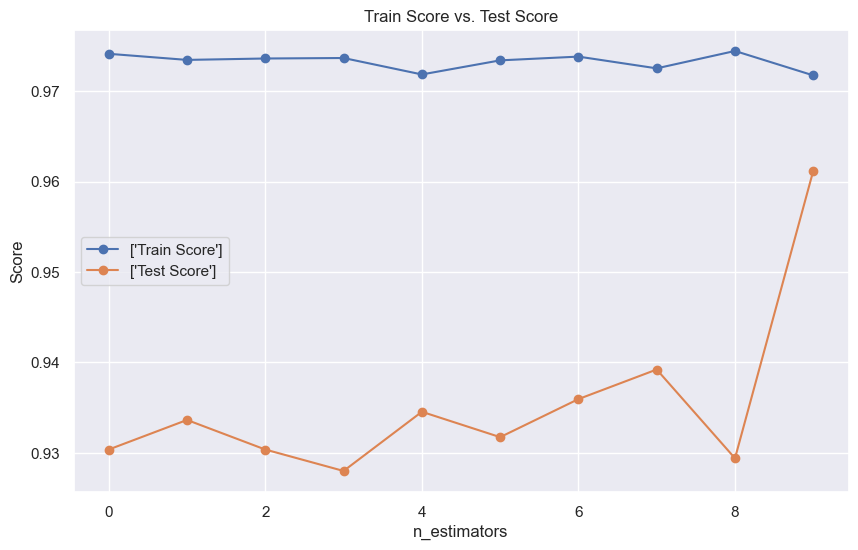

In [82]:
XGB_modified = make_pipeline(
    StandardScaler(),
    XGBClassifier(**params)
)

train_scores, valid_scores, valid_predictions, test_predictions = cross_val_model(XGB_modified, n_splits=10, use_all_features=False)

train_test_log(train_scores, valid_scores)

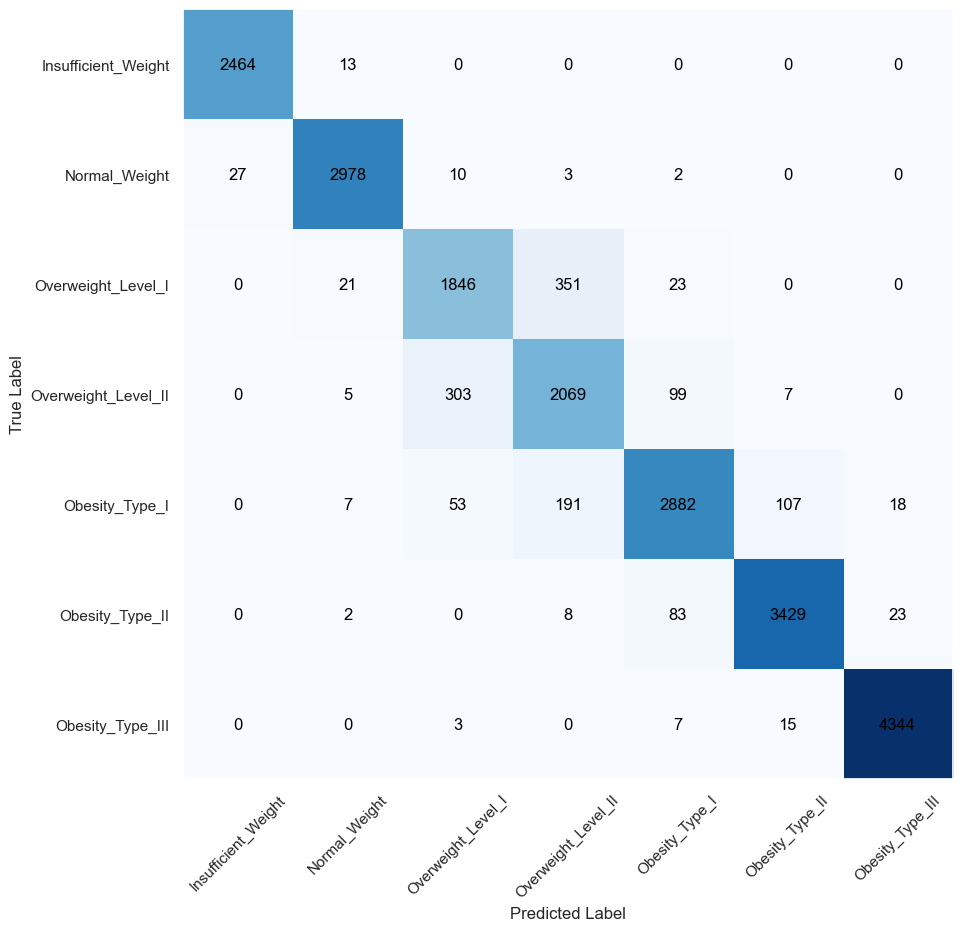

In [83]:
confusion_matrix_plot(valid_predictions)

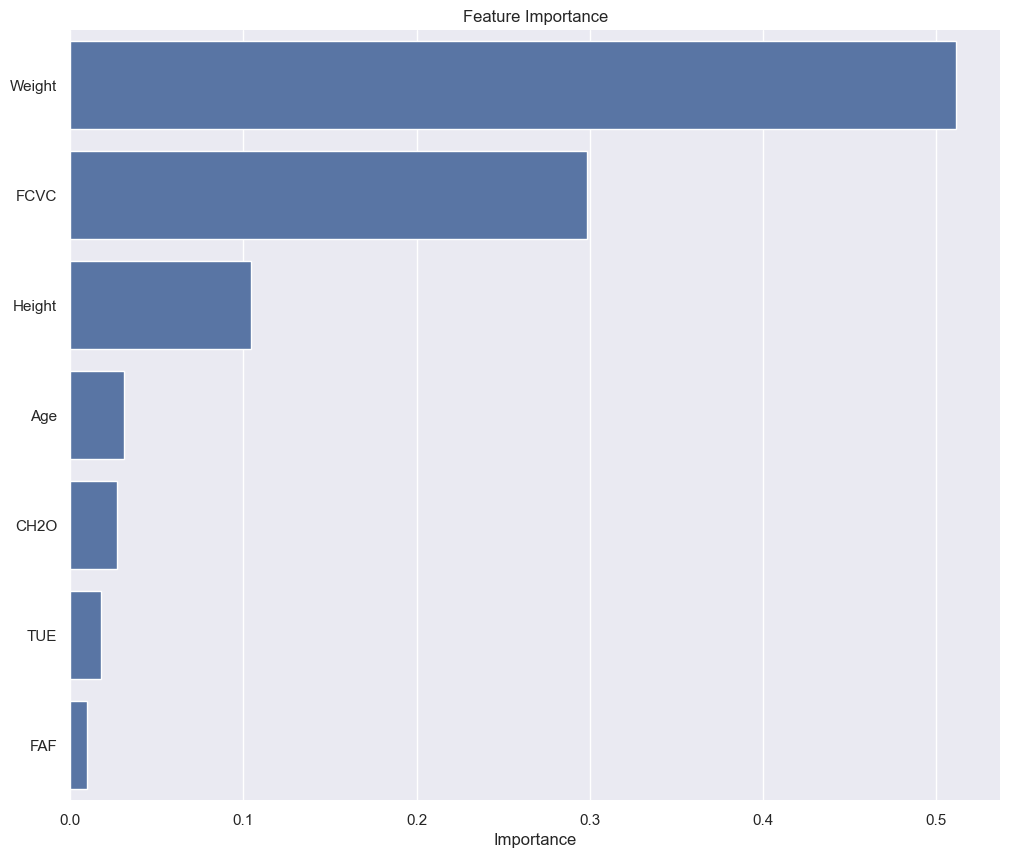

In [84]:
feature_importance_plot(XGB_modified, use_all_features=False)

## Exclude "BMI" feature when building Model

----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:	0.9625400835681663
Test Accuracy Score:	0.8919982509838216
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:	0.9632202895734137
Test Accuracy Score:	0.8941845212068211
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:	0.9627344281410941
Test Accuracy Score:	0.8889374726716223
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 4
Train Accuracy Sco

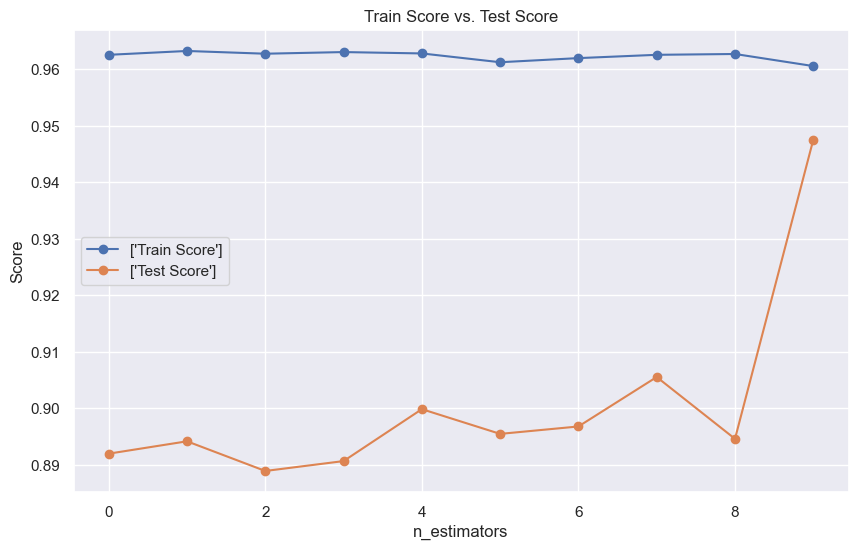

In [152]:
train = train.drop("BMI", axis=1)
test = test.drop("BMI", axis=1)

X = train.loc[:, train.columns != "NObeyesdad"]
y = train[["NObeyesdad"]]

XGB_modified_2 = make_pipeline(
    MEstimateEncoder(cols=categorical_features),
    StandardScaler(),
    XGBClassifier(**params)
)

train_scores, valid_scores, valid_predictions, test_predictions = cross_val_model(XGB_modified_2, n_splits=10, use_all_features=True)

train_test_log(train_scores, valid_scores)

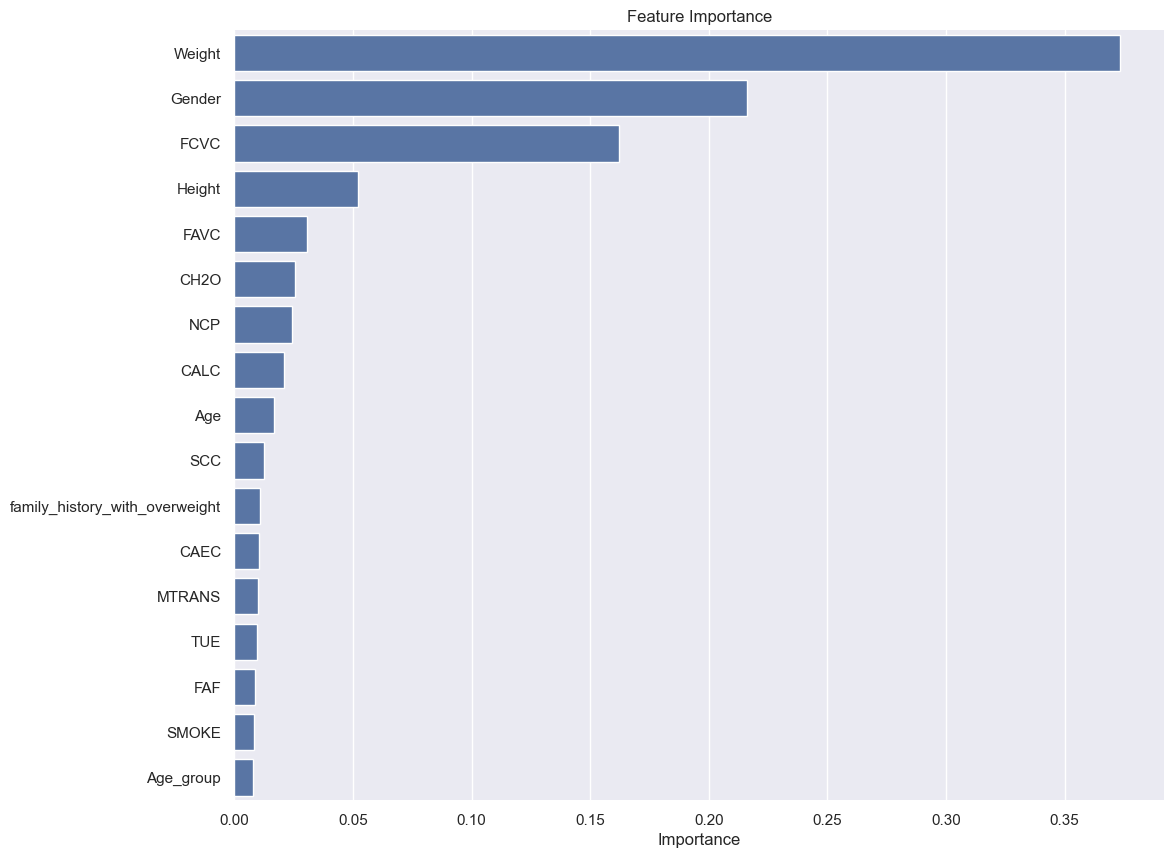

In [153]:
feature_importance_plot(XGB_modified_2)

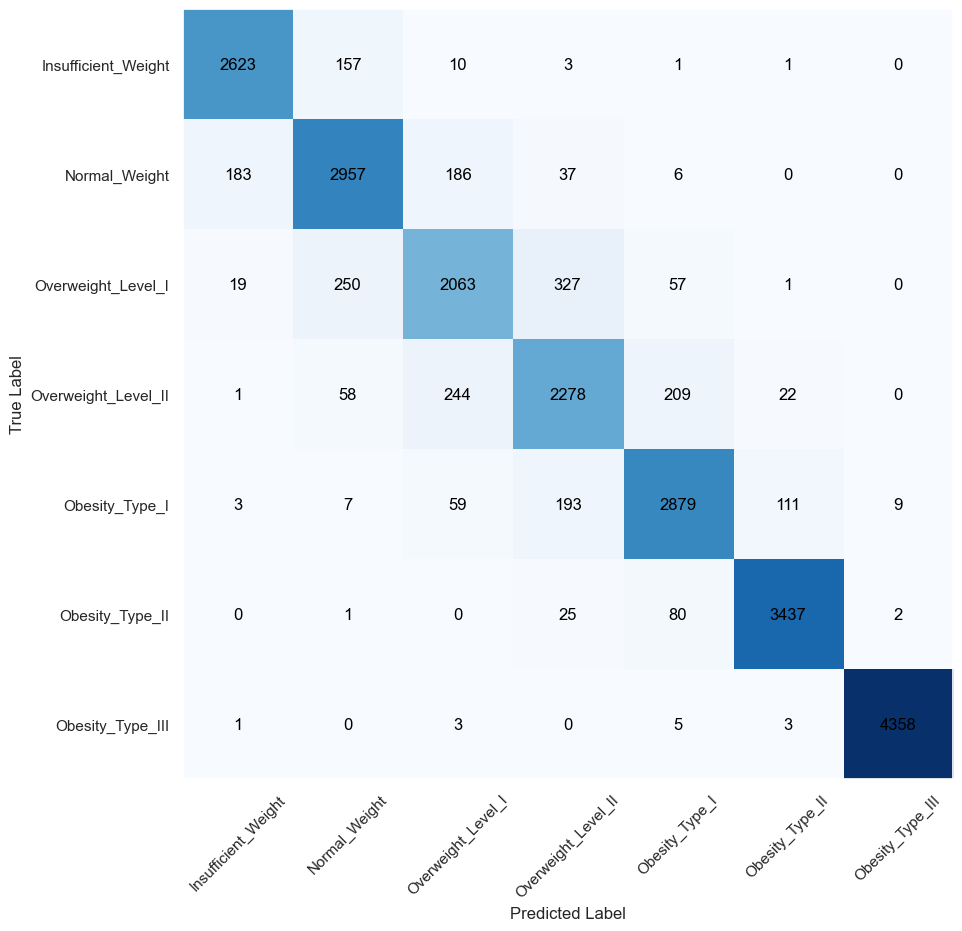

In [154]:
confusion_matrix_plot(valid_predictions)

# Conclusion